In [1]:
import monai

In [2]:
import os 
from glob import glob 
import shutil 
from tqdm import tqdm 
import dicom2nifti
import numpy as np 
import nibabel as nib 
from monai.transforms import (
    compose , 
    EnsureChannelFirstd , # instead of AddChanneld
    LoadImaged , 
    Resized , 
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    

)
from monai.data import DataLoader , Dataset, CacheDataset
from monai.utils import set_determinism 
from monai.utils import first
import matplotlib.pyplot as plt 



In [3]:
from monai.transforms.compose import Compose 

In [4]:
in_dir = "C:/Users/TRETEC/Desktop/Segmenetation/Task02_Heart/nifti_files "

c:\Users\TRETEC\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


Contents of C:/Users/TRETEC/Desktop/Segmenetation/Task02_Heart/nifti_files: ['images', 'labels', 'TestSegmentation', 'TestVolumes', 'TrainSegmentation', 'TrainVolumes']
Glob pattern for training volumes: C:/Users/TRETEC/Desktop/Segmenetation/Task02_Heart/nifti_files\TrainVolumes\*.nii.gz
Glob pattern for training segmentations: C:/Users/TRETEC/Desktop/Segmenetation/Task02_Heart/nifti_files\TrainSegmentation\*.nii.gz
Glob pattern for testing volumes: C:/Users/TRETEC/Desktop/Segmenetation/Task02_Heart/nifti_files\TestVolumes\*.nii.gz
Glob pattern for testing segmentations: C:/Users/TRETEC/Desktop/Segmenetation/Task02_Heart/nifti_files\TestSegmentation\*.nii.gz
Training volumes: ['C:/Users/TRETEC/Desktop/Segmenetation/Task02_Heart/nifti_files\\TrainVolumes\\h_003_0.nii.gz', 'C:/Users/TRETEC/Desktop/Segmenetation/Task02_Heart/nifti_files\\TrainVolumes\\h_004_0.nii.gz', 'C:/Users/TRETEC/Desktop/Segmenetation/Task02_Heart/nifti_files\\TrainVolumes\\h_005_0.nii.gz', 'C:/Users/TRETEC/Desktop/S

Loading dataset: 100%|██████████| 4/4 [00:15<00:00,  3.87s/it]


Training patient 'vol' shape: torch.Size([1, 1, 128, 128, 64]), 'seg' shape: torch.Size([1, 1, 128, 128, 64])


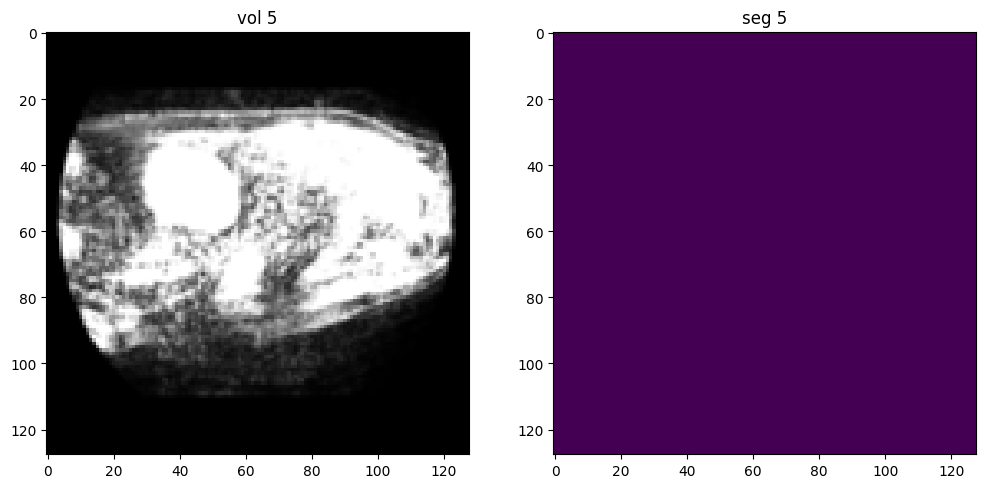

In [ ]:


def preparePatient(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=True):
    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)

    # Normalize the directory path by stripping any whitespace
    in_dir = in_dir.strip().replace("\\", "/")  # Remove trailing spaces and replace backslashes

    # Check if the directory exists
    if not os.path.exists(in_dir):
        print(f"Error: The directory '{in_dir}' does not exist.")
        return None, None

    # Print the directory content to ensure the path is correct
    print(f"Contents of {in_dir}: {os.listdir(in_dir)}")

    # Verify glob patterns
    train_volumes_pattern = os.path.join(in_dir, "TrainVolumes", "*.nii.gz")
    train_segmentation_pattern = os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")
    test_volumes_pattern = os.path.join(in_dir, "TestVolumes", "*.nii.gz")
    test_segmentation_pattern = os.path.join(in_dir, "TestSegmentation", "*.nii.gz")

    print(f"Glob pattern for training volumes: {train_volumes_pattern}")
    print(f"Glob pattern for training segmentations: {train_segmentation_pattern}")
    print(f"Glob pattern for testing volumes: {test_volumes_pattern}")
    print(f"Glob pattern for testing segmentations: {test_segmentation_pattern}")

    # Attempt to load the file paths
    path_train_volumes = sorted(glob(train_volumes_pattern))
    path_train_segmentation = sorted(glob(train_segmentation_pattern))

    path_test_volumes = sorted(glob(test_volumes_pattern))
    path_test_segmentation = sorted(glob(test_segmentation_pattern))

    # Debugging: Print file paths
    print(f"Training volumes: {path_train_volumes}")
    print(f"Training segmentations: {path_train_segmentation}")
    print(f"Testing volumes: {path_test_volumes}")
    print(f"Testing segmentations: {path_test_segmentation}")

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                   zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                  zip(path_test_volumes, path_test_segmentation)]

    # Debugging: Check dataset sizes
    print(f"Number of training files: {len(train_files)}")
    print(f"Number of testing files: {len(test_files)}")

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader
    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

# Transforms for training and testing data
train_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5, 1.5, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["vol", "seg"], source_key="vol"),
        Resized(keys=["vol", "seg"], spatial_size=[128, 128, 64]),
        ToTensord(keys=["vol", "seg"]),
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5, 1.5, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["vol", "seg"], source_key="vol"),
        Resized(keys=["vol", "seg"], spatial_size=[128, 128, 64]),
        ToTensord(keys=["vol", "seg"]),
    ]
)

def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can see if it is okay or if you need 
    to change/delete something.
    """
    check_patient_train, check_patient_test = data

    # Fetch a batch from the DataLoader
    try:
        view_train_patient = next(iter(check_patient_train)) if train else None
        view_test_patient = next(iter(check_patient_test)) if test else None
    except StopIteration:
        print("Error: DataLoader is empty.")
        return

    # Debugging: Check if view_train_patient or view_test_patient is None
    if train and view_train_patient is None:
        print("Error: Training patient data is None.")
    if test and view_test_patient is None:
        print("Error: Testing patient data is None.")
    
    # Display training data if specified
    if train and view_train_patient is not None:
        if "vol" not in view_train_patient or "seg" not in view_train_patient:
            print("Error: 'vol' or 'seg' key is missing in training patient data.")
            return

        # Debugging: Check if SLICE_NUMBER is within the range of available slices
        vol_shape = view_train_patient["vol"].shape
        seg_shape = view_train_patient["seg"].shape
        print(f"Training patient 'vol' shape: {vol_shape}, 'seg' shape: {seg_shape}")

        if SLICE_NUMBER >= vol_shape[4]:
            print(f"Error: SLICE_NUMBER {SLICE_NUMBER} is out of bounds for 'vol' with {vol_shape[4]} slices.")
            return

        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    # Display testing data if specified
    if test and view_test_patient is not None:
        if "vol" not in view_test_patient or "seg" not in view_test_patient:
            print("Error: 'vol' or 'seg' key is missing in testing patient data.")
            return

        # Debugging: Check if SLICE_NUMBER is within the range of available slices
        vol_shape = view_test_patient["vol"].shape
        seg_shape = view_test_patient["seg"].shape
        print(f"Testing patient 'vol' shape: {vol_shape}, 'seg' shape: {seg_shape}")

        if SLICE_NUMBER >= vol_shape[4]:
            print(f"Error: SLICE_NUMBER {SLICE_NUMBER} is out of bounds for 'vol' with {vol_shape[4]} slices.")
            return

        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

# Example usage
in_dir = "C:/Users/TRETEC/Desktop/Segmenetation/Task02_Heart/nifti_files"
patient = preparePatient(in_dir)
if patient:  # Ensure that patient data is loaded
    show_patient(patient, SLICE_NUMBER=5)


Training patient 'vol' shape: torch.Size([1, 1, 128, 128, 64]), 'seg' shape: torch.Size([1, 1, 128, 128, 64])


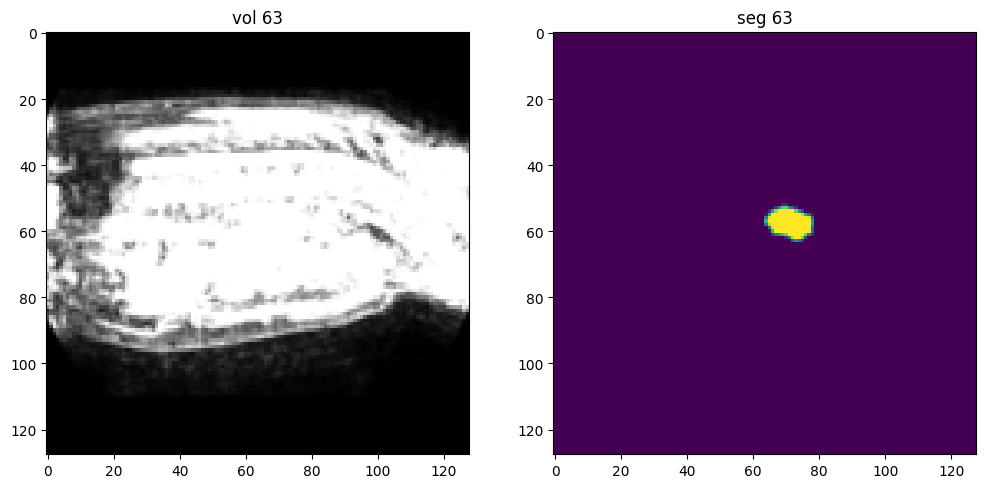

In [6]:
show_patient(patient , SLICE_NUMBER= 63)

In [ ]:
print(f"Glob pattern for training volumes: {os.path.join(in_dir, 'TrainVolumes', '*.nii.gz')}")
print(f"Glob pattern for training segmentations: {os.path.join(in_dir, 'TrainSegmentation', '*.nii.gz')}")


In [ ]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm

def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights` 
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)


                
def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

In [24]:


def prepare4(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=True):
    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)

    # Normalize the directory path by stripping any whitespace
    in_dir = in_dir.strip().replace("\\", "/")  # Remove trailing spaces and replace backslashes

    # Check if the directory exists
    if not os.path.exists(in_dir):
        print(f"Error: The directory '{in_dir}' does not exist.")
        return None, None

    # Print the directory content to ensure the path is correct
    print(f"Contents of {in_dir}: {os.listdir(in_dir)}")

    # Verify glob patterns
    train_volumes_pattern = os.path.join(in_dir, "TrainVolumes", "*.nii.gz")
    train_segmentation_pattern = os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")
    test_volumes_pattern = os.path.join(in_dir, "TestVolumes", "*.nii.gz")
    test_segmentation_pattern = os.path.join(in_dir, "TestSegmentation", "*.nii.gz")

    print(f"Glob pattern for training volumes: {train_volumes_pattern}")
    print(f"Glob pattern for training segmentations: {train_segmentation_pattern}")
    print(f"Glob pattern for testing volumes: {test_volumes_pattern}")
    print(f"Glob pattern for testing segmentations: {test_segmentation_pattern}")

    # Attempt to load the file paths
    path_train_volumes = sorted(glob(train_volumes_pattern))
    path_train_segmentation = sorted(glob(train_segmentation_pattern))

    path_test_volumes = sorted(glob(test_volumes_pattern))
    path_test_segmentation = sorted(glob(test_segmentation_pattern))

    # Debugging: Print file paths
    print(f"Training volumes: {path_train_volumes}")
    print(f"Training segmentations: {path_train_segmentation}")
    print(f"Testing volumes: {path_test_volumes}")
    print(f"Testing segmentations: {path_test_segmentation}")

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                   zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                  zip(path_test_volumes, path_test_segmentation)]

    # Debugging: Check dataset sizes
    print(f"Number of training files: {len(train_files)}")
    print(f"Number of testing files: {len(test_files)}")

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader
    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

# Transforms for training and testing data
from monai.transforms import RandFlipd , RandRotate90d , RandShiftIntensityd , RandScaleIntensityd , RandZoomd , RandAffined
def get_augmentation_transforms(pixdim=(1.5, 1.5, 1.0), spatial_size=[128, 128, 64]):
    """
    Returns a set of data augmentation transforms to be used for training.
    """
    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            # Data Augmentation Techniques
            RandFlipd(keys=["vol", "seg"], spatial_axis=0, prob=0.5),   # Randomly flip along the first axis
            RandFlipd(keys=["vol", "seg"], spatial_axis=1, prob=0.5),   # Randomly flip along the second axis
            RandFlipd(keys=["vol", "seg"], spatial_axis=2, prob=0.5),   # Randomly flip along the third axis
            RandRotate90d(keys=["vol", "seg"], prob=0.5, max_k=3),      # Randomly rotate by 90 degrees
            RandShiftIntensityd(keys=["vol"], offsets=0.1, prob=0.5),   # Randomly shift intensity
            RandScaleIntensityd(keys=["vol"], factors=0.1, prob=0.5),   # Randomly scale intensity
            RandZoomd(keys=["vol", "seg"], min_zoom=0.9, max_zoom=1.1, prob=0.5),  # Random zoom
            RandAffined(
                keys=["vol", "seg"],
                prob=0.5,
                rotate_range=(0.1, 0.1, 0.1),
                shear_range=(0.1, 0.1, 0.1),
                translate_range=(5, 5, 5),
                scale_range=(0.1, 0.1, 0.1),
                mode=("bilinear", "nearest")
            ),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   # Resize to the desired output size
            ToTensord(keys=["vol", "seg"]),                             # Convert to Tensor
        ]
    )
    return train_transforms

    

test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5, 1.5, 1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["vol", "seg"], source_key="vol"),
        Resized(keys=["vol", "seg"], spatial_size=[128, 128, 64]),
        ToTensord(keys=["vol", "seg"]),
    ]
)

        


c:\Users\TRETEC\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [25]:
train_transforms = get_augmentation_transforms()

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from tqdm import tqdm

def train_model(data_dir, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Prepare data loaders
    train_loader, test_loader = prepare4(data_dir, cache=True)

    # Define the model, loss function, and optimizer
    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=1,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

    loss_function = DiceLoss(sigmoid=True)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Metric to evaluate the model
    dice_metric = DiceMetric(include_background=True, reduction="mean")

    # Training loop
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        epoch_loss = 0
        step = 0

        # Training phase
        for batch_data in tqdm(train_loader, desc="Training"):
            inputs, labels = batch_data["vol"].to(device), batch_data["seg"].to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            step += 1

        print(f"Epoch {epoch+1}, Average Loss: {epoch_loss/step:.4f}")

        # Evaluation phase
        model.eval()
        with torch.no_grad():
            dice_score = 0.0
            for test_data in tqdm(test_loader, desc="Validation"):
                test_inputs, test_labels = test_data["vol"].to(device), test_data["seg"].to(device)
                test_outputs = model(test_inputs)
                
                # Calculate Dice score
                dice_metric(y_pred=test_outputs, y=test_labels)
            
            # Get the final Dice score
            dice_score = dice_metric.aggregate().item()
            dice_metric.reset()
            print(f"Validation Dice Score: {dice_score:.4f}")

    print("Training complete.")


In [ ]:
# Specify the path to your data directory
data_dir = in_dir

# Launch training
train_model(data_dir=data_dir, num_epochs=50 )
